正在加载数据集...
加载数据集完成:
  训练集: 20492 样本
  验证集: 5072 样本
  测试集: 6460 样本
  任务数: 12
  NR-AR 正例比例: 0.0404
  NR-AR-LBD 正例比例: 0.0324
  NR-AhR 正例比例: 0.1177
  ...

正在创建分子图数据集...
处理训练集:
  处理 1000 个分子...
  处理 2000 个分子...
  处理 3000 个分子...
  处理 4000 个分子...
  处理 5000 个分子...
  处理 6000 个分子...
  处理 7000 个分子...
  处理 8000 个分子...
  处理 9000 个分子...
  处理 10000 个分子...
  处理 11000 个分子...
  处理 12000 个分子...
  处理 13000 个分子...
  处理 14000 个分子...
  处理 15000 个分子...
  处理 16000 个分子...
  处理 17000 个分子...
  处理 18000 个分子...
  处理 19000 个分子...
  处理 20000 个分子...
  成功处理 20492 个分子（共 20492 个）
处理验证集:
  处理 1000 个分子...
  处理 2000 个分子...
  处理 3000 个分子...
  处理 4000 个分子...
  处理 5000 个分子...
  成功处理 5072 个分子（共 5072 个）
处理测试集:


[21:04:33] WARNING: not removing hydrogen atom without neighbors
[21:04:33] WARNING: not removing hydrogen atom without neighbors
[21:04:33] WARNING: not removing hydrogen atom without neighbors
[21:04:33] WARNING: not removing hydrogen atom without neighbors


  处理 1000 个分子...
  处理 2000 个分子...
  处理 3000 个分子...
  处理 4000 个分子...
  处理 5000 个分子...
  处理 6000 个分子...
  成功处理 6460 个分子（共 6460 个）

使用设备: cuda

模型结构:
GATTox21(
  (gat1): GATConv(
    (fc): Linear(in_features=65, out_features=512, bias=False)
    (feat_drop): Dropout(p=0.2, inplace=False)
    (attn_drop): Dropout(p=0.2, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (gat2): GATConv(
    (fc): Linear(in_features=512, out_features=64, bias=False)
    (feat_drop): Dropout(p=0.2, inplace=False)
    (attn_drop): Dropout(p=0.2, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (predict): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=12, bias=True)
  )
)

开始训练GAT模型...
Epoch: 001, Train Loss: 0.2695, Val Mean AUC: 0.6898, Val Median AUC: 0.6671
Epoch: 002, Train Loss: 0.2341, Val Mean AUC: 0.7066, Val Median AUC: 0.6847
Epoch: 003, T

<Figure size 1200x500 with 0 Axes>

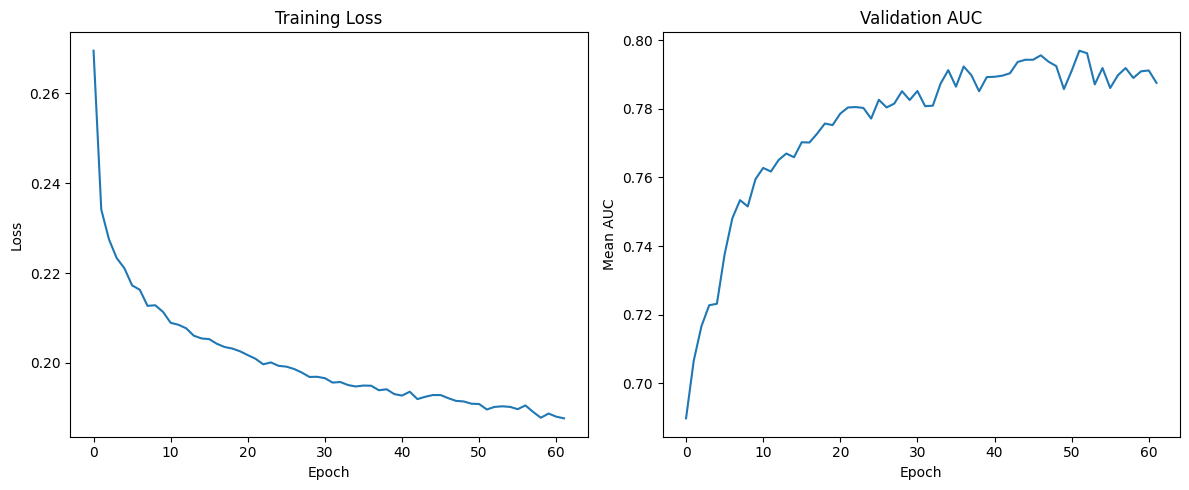

<Figure size 1500x1000 with 0 Axes>

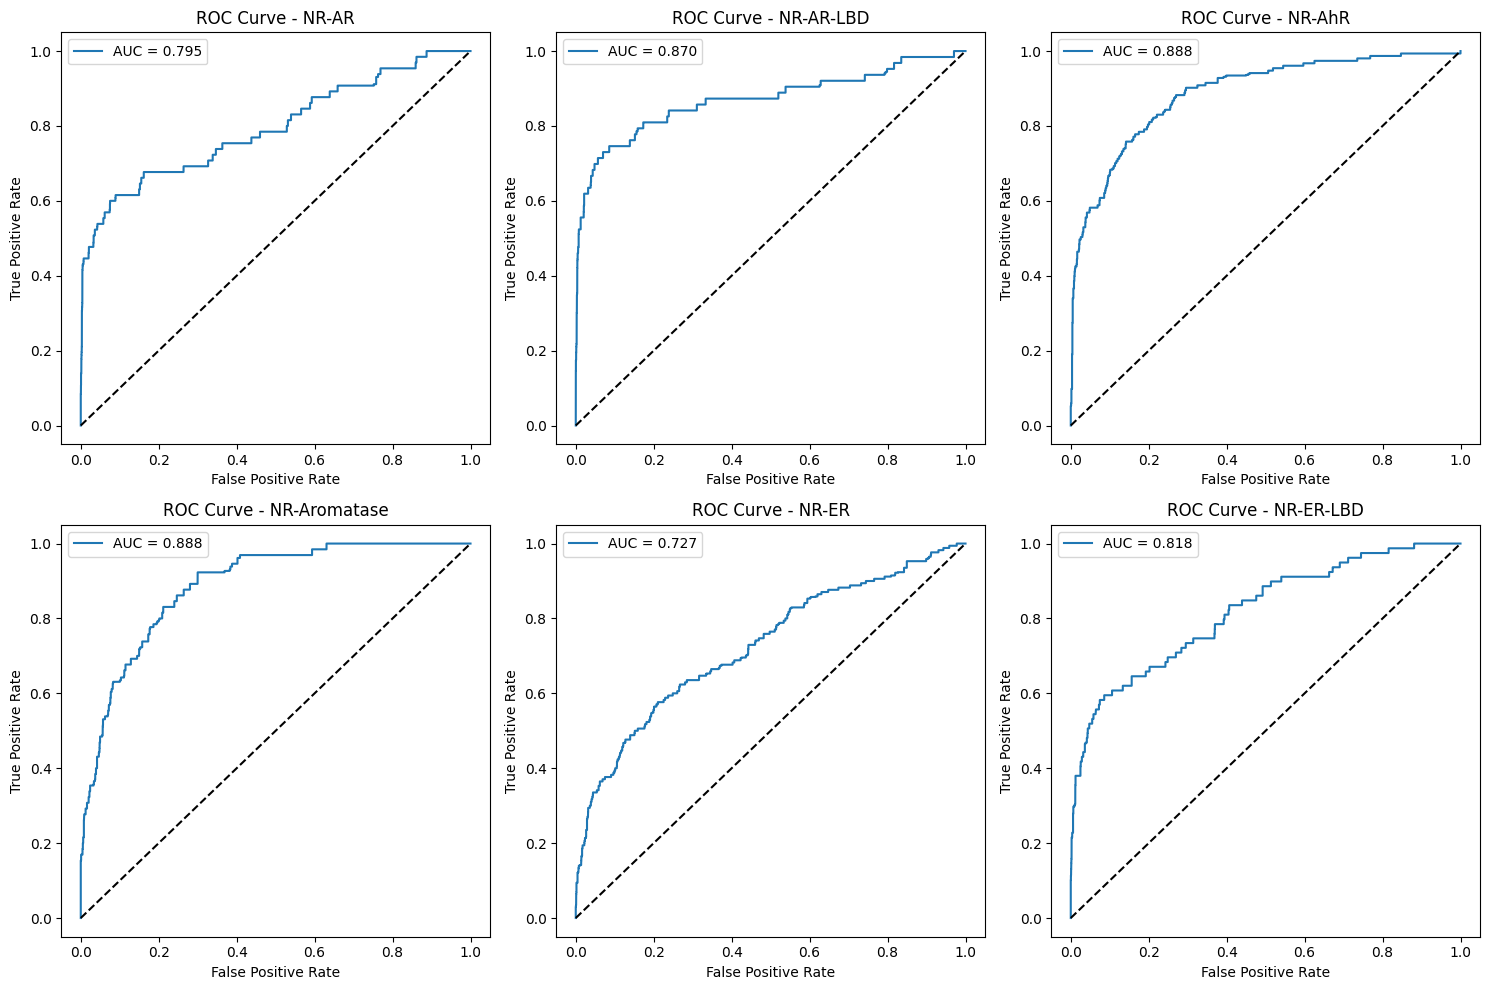

<Figure size 1200x500 with 0 Axes>

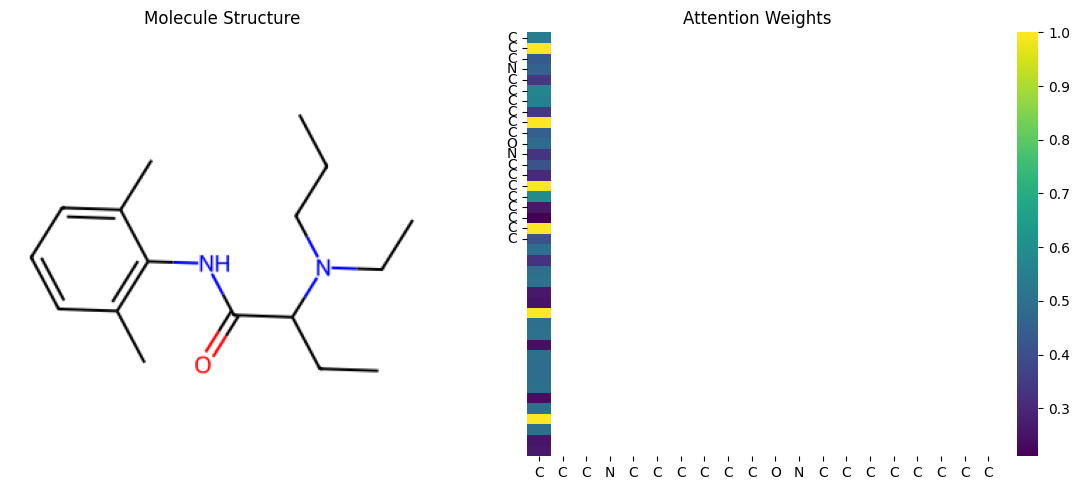

<Figure size 1200x500 with 0 Axes>

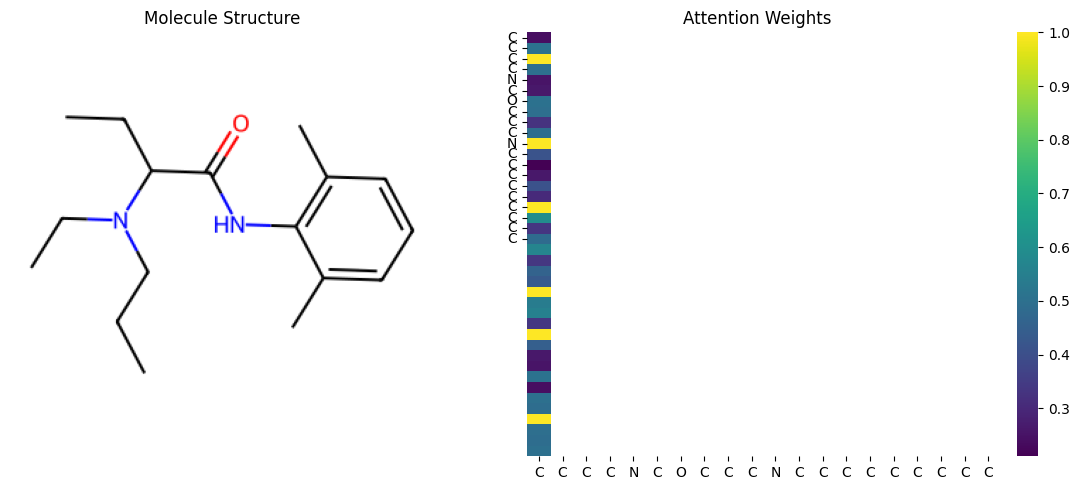

<Figure size 1200x500 with 0 Axes>

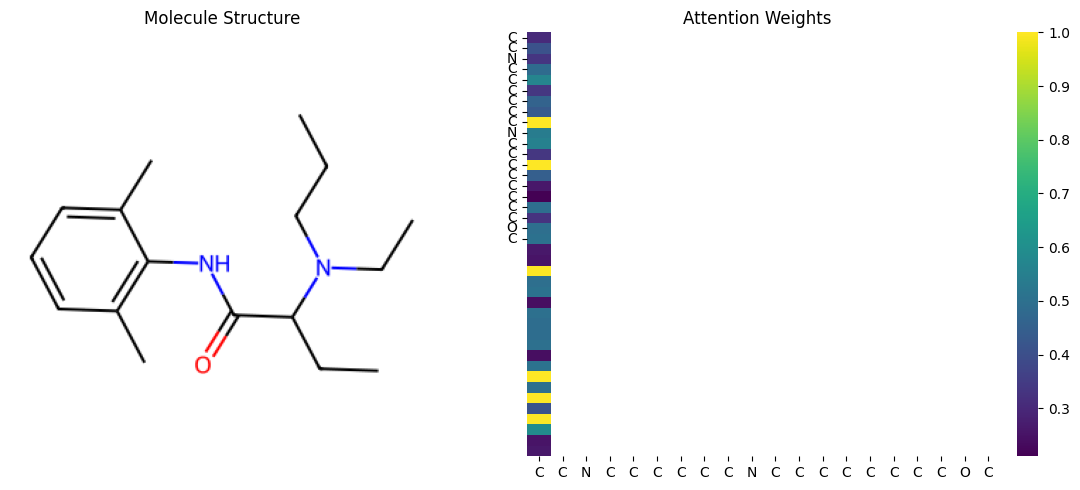

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import roc_auc_score, roc_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn.pytorch import GATConv
from torch.utils.data import Dataset, DataLoader
import time
import warnings
warnings.filterwarnings('ignore')

# --------------------- 1. 数据加载和预处理 ---------------------

def load_datasets(train_path='tox21_train.csv', val_path='tox21_val.csv', test_path='tox21_test.csv'):
    """加载Tox21数据集"""
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    
    # 获取任务名称（除SMILES和mol_id外的所有列）
    task_names = [col for col in train_df.columns if col not in ['smiles', 'mol_id']]
    
    print(f"加载数据集完成:")
    print(f"  训练集: {len(train_df)} 样本")
    print(f"  验证集: {len(val_df)} 样本")
    print(f"  测试集: {len(test_df)} 样本")
    print(f"  任务数: {len(task_names)}")
    
    # 打印类别分布
    for task in task_names[:3]:  # 只打印前3个任务的分布
        pos_train = train_df[task].sum() / train_df[task].count()
        print(f"  {task} 正例比例: {pos_train:.4f}")
    
    print("  ...")
    
    return train_df, val_df, test_df, task_names

# --------------------- 2. 分子图构建 ---------------------

def atom_features(atom):
    """将RDKit原子对象转换为特征向量"""
    # 原子类型的独热编码（考虑常见元素）
    atom_types = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na',
                'Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb',
                'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H',
                'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr',
                'Cr', 'Pt', 'Hg', 'Pb', 'Unknown']
    atom_type = [0] * len(atom_types)
    atom_type_idx = atom_types.index(atom.GetSymbol()) if atom.GetSymbol() in atom_types else -1
    atom_type[atom_type_idx] = 1
    
    # 原子的度（与其他原子连接数量）
    degree = [0] * 6
    degree[min(atom.GetDegree(), 5)] = 1
    
    # 形式电荷 (-2, -1, 0, 1, 2) -> 索引 (0, 1, 2, 3, 4)
    formal_charge = [0] * 5
    formal_charge[min(atom.GetFormalCharge() + 2, 4)] = 1
    
    # 杂化类型
    hybridization_types = [
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2
    ]
    hybridization = [0] * len(hybridization_types)
    hyb_idx = hybridization_types.index(atom.GetHybridization()) if atom.GetHybridization() in hybridization_types else -1
    if hyb_idx >= 0:
        hybridization[hyb_idx] = 1
    
    # 是否为芳香族
    is_aromatic = [atom.GetIsAromatic()]
    
    # 原子质量（归一化）
    mass = [atom.GetMass() * 0.01]
    
    # 原子手性
    chirality = [0] * 3
    try:
        chirality[int(atom.GetChiralTag())] = 1
    except:
        pass
    
    # 连接特征
    features = atom_type + degree + formal_charge + hybridization + is_aromatic + mass + chirality
    return features

def smiles_to_dgl_graph(smiles):
    """将SMILES字符串转换为DGL图"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # 获取原子特征
    node_features = []
    for atom in mol.GetAtoms():
        node_features.append(atom_features(atom))
    
    # 创建DGL图
    g = dgl.graph(([], []), idtype=torch.int32)
    g.add_nodes(len(node_features))
    g.ndata['h'] = torch.tensor(node_features, dtype=torch.float)
    
    # 添加边
    src_list = []
    dst_list = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # 添加双向边
        src_list.extend([i, j])
        dst_list.extend([j, i])
    
    # 如果有边，将其添加到图中 - 确保数据类型为int32
    if src_list:
        g.add_edges(torch.tensor(src_list, dtype=torch.int32), 
                   torch.tensor(dst_list, dtype=torch.int32))
    
    # 添加自环，确保所有节点都有入度
    num_nodes = g.num_nodes()
    if num_nodes > 0:
        # 获取所有节点的入度
        in_degrees = g.in_degrees()
        # 找出入度为0的节点
        zero_in_nodes = torch.where(in_degrees == 0)[0]
        # 为这些节点添加自环 - 确保数据类型为int32
        if len(zero_in_nodes) > 0:
            g.add_edges(zero_in_nodes.to(torch.int32), zero_in_nodes.to(torch.int32))
    
    return g

def create_tox21_dataset(df, task_names):
    """从DataFrame创建数据集"""
    graphs = []
    labels = []
    smiles_list = []
    valid_count = 0
    
    for idx, row in df.iterrows():
        smiles = row['smiles']
        g = smiles_to_dgl_graph(smiles)
        if g is None:
            continue
        
        # 收集标签（处理缺失值）
        y = []
        for task in task_names:
            if pd.isna(row[task]):
                y.append(float('nan'))
            else:
                y.append(float(row[task]))
        
        graphs.append(g)
        labels.append(y)
        smiles_list.append(smiles)
        valid_count += 1
        
        # 显示进度
        if valid_count % 1000 == 0:
            print(f"  处理 {valid_count} 个分子...")
    
    print(f"  成功处理 {valid_count} 个分子（共 {len(df)} 个）")
    return graphs, torch.tensor(labels, dtype=torch.float), smiles_list

# --------------------- 3. 图神经网络模型 ---------------------

class GATTox21(nn.Module):
    """图注意力网络用于Tox21毒性预测"""
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads=8, dropout=0.2):
        super(GATTox21, self).__init__()
        
        # 多头图注意力层
        self.gat1 = GATConv(in_dim, hidden_dim, num_heads=num_heads, 
                           feat_drop=dropout, attn_drop=dropout,
                           allow_zero_in_degree=True)  # 允许入度为0的节点
        
        # 第二层图注意力
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, num_heads=1, 
                           feat_drop=dropout, attn_drop=dropout,
                           allow_zero_in_degree=True)  # 允许入度为0的节点
        
        # 输出层（多任务分类）
        self.predict = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward(self, g):
        h = g.ndata['h']
        
        # 第一层GAT
        h = self.gat1(g, h)
        h = F.relu(h)
        h = h.view(h.shape[0], -1)  # 将多头注意力结果连接起来
        
        # 第二层GAT
        h = self.gat2(g, h)
        h = F.relu(h.squeeze(1))
        
        # 读出阶段：计算图级别表示
        with g.local_scope():
            g.ndata['h'] = h
            # 使用平均池化获取图表示
            hg = dgl.mean_nodes(g, 'h')
            return self.predict(hg)
    
    def get_attention_weights(self, g):
        """返回注意力权重用于可视化"""
        h = g.ndata['h']
        _, attn_weights = self.gat1(g, h, get_attention=True)
        return attn_weights

# --------------------- 4. 数据加载器 ---------------------

class GraphDataset(Dataset):
    """图数据集封装"""
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

def collate_fn(samples):
    """收集每批数据的函数"""
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    batched_labels = torch.stack(labels)
    return batched_graph, batched_labels

# --------------------- 5. 训练与评估 ---------------------

def train_epoch(model, optimizer, dataloader, criterion, device):
    """训练一个epoch"""
    model.train()
    total_loss = 0
    
    for bg, labels in dataloader:
        bg = bg.to(device)
        labels = labels.to(device)
        
        # 前向传播
        logits = model(bg)
        
        # 处理NaN值
        mask = ~torch.isnan(labels)
        loss = criterion(logits[mask], labels[mask])
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, task_names, device):
    """评估模型性能"""
    model.eval()
    y_true = {task: [] for task in task_names}
    y_scores = {task: [] for task in task_names}
    
    with torch.no_grad():
        for bg, labels in dataloader:
            bg = bg.to(device)
            logits = model(bg).cpu()
            labels = labels.cpu().numpy()
            
            # 收集预测结果
            for i, task in enumerate(task_names):
                task_labels = labels[:, i]
                valid_indices = ~np.isnan(task_labels)
                
                if np.sum(valid_indices) > 0:
                    y_true[task].extend(task_labels[valid_indices])
                    y_scores[task].extend(logits[:, i].numpy()[valid_indices])
    
    # 计算AUC
    results = {}
    for task in task_names:
        if len(y_true[task]) > 0 and len(np.unique(y_true[task])) > 1:
            results[task] = roc_auc_score(y_true[task], y_scores[task])
        else:
            results[task] = float('nan')
    
    # 计算平均指标
    valid_aucs = [auc for auc in results.values() if not np.isnan(auc)]
    mean_auc = np.mean(valid_aucs) if valid_aucs else float('nan')
    median_auc = np.median(valid_aucs) if valid_aucs else float('nan')
    
    return results, mean_auc, median_auc, y_true, y_scores

# --------------------- 6. 可视化函数 ---------------------

def plot_training_curve(train_losses, val_aucs):
    """绘制训练曲线"""
    plt.figure(figsize=(12, 5))
    
    # 绘制训练损失
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    
    # 绘制验证AUC
    plt.subplot(1, 2, 2)
    plt.plot(val_aucs)
    plt.xlabel('Epoch')
    plt.ylabel('Mean AUC')
    plt.title('Validation AUC')
    
    plt.tight_layout()
    return plt.gcf()

def plot_roc_curves(y_true, y_scores, task_names, num_tasks=6):
    """为多个任务绘制ROC曲线"""
    # 选择要展示的任务（前num_tasks个）
    selected_tasks = list(y_true.keys())[:num_tasks]
    
    plt.figure(figsize=(15, 10))
    
    for i, task in enumerate(selected_tasks):
        if len(y_true[task]) == 0 or len(np.unique(y_true[task])) <= 1:
            continue
            
        # 计算ROC曲线
        fpr, tpr, _ = roc_curve(y_true[task], y_scores[task])
        auc = roc_auc_score(y_true[task], y_scores[task])
        
        # 绘制曲线
        plt.subplot(2, 3, i + 1)
        plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
        plt.plot([0, 1], [0, 1], 'k--')  # 对角线
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {task}')
        plt.legend()
    
    plt.tight_layout()
    return plt.gcf()

def visualize_attention(model, smiles, device, mol_idx=0):
    """可视化分子的注意力权重"""
    mol = Chem.MolFromSmiles(smiles)
    g = smiles_to_dgl_graph(smiles)
    g = g.to(device)
    
    # 获取注意力权重
    with torch.no_grad():
        attn_weights = model.get_attention_weights(g)
    
    # 平均多头注意力权重
    avg_attn = attn_weights.mean(dim=1).cpu().numpy()
    
    # 绘制分子结构
    from rdkit.Chem import Draw
    
    # 提取原子符号
    atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    
    # 绘制注意力热力图
    plt.figure(figsize=(12, 5))
    
    # 绘制分子
    plt.subplot(1, 2, 1)
    img = Draw.MolToImage(mol, size=(300, 300))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Molecule Structure')
    
    # 绘制注意力热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(avg_attn, cmap='viridis', xticklabels=atom_symbols, yticklabels=atom_symbols)
    plt.title('Attention Weights')
    
    plt.tight_layout()
    return plt.gcf()


def save_prediction_results(model, test_loader, task_names, device, threshold=0.5, output_file='prediction_results.csv'):
    """保存每个任务的预测结果到CSV文件"""
    model.eval()
    
    # 准备存储结果的列表
    results = []
    
    with torch.no_grad():
        sample_id = 0
        for bg, labels in test_loader:
            bg = bg.to(device)
            labels = labels.cpu().numpy()
            
            # 获取预测值
            logits = model(bg).cpu().numpy()
            
            # 对每个样本
            for i in range(labels.shape[0]):
                # 对每个任务
                for t, task in enumerate(task_names):
                    # 如果标签不是NaN
                    if not np.isnan(labels[i, t]):
                        # 获取预测概率
                        pred_prob = 1.0 / (1.0 + np.exp(-logits[i, t]))  # sigmoid
                        
                        # 获取预测的二元标签
                        pred_label = 1 if pred_prob >= threshold else 0
                        
                        # 获取真实标签
                        true_label = int(labels[i, t])
                        
                        # 添加到结果列表
                        results.append({
                            'sample_id': sample_id,
                            'task': task,
                            'predicted_prob': pred_prob,
                            'predicted_label': pred_label,
                            'true_label': true_label
                        })
                
                sample_id += 1
    
    # 转换为DataFrame并保存
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)
    print(f"预测结果已保存到 {output_file}")
    
    # 计算每个任务的准确率
    task_accuracies = {}
    for task in task_names:
        task_df = results_df[results_df['task'] == task]
        acc = (task_df['predicted_label'] == task_df['true_label']).mean()
        task_accuracies[task] = acc
    
    # 保存任务准确率
    accuracy_df = pd.DataFrame([task_accuracies]).T.reset_index()
    accuracy_df.columns = ['task', 'accuracy']
    accuracy_df.to_csv('task_accuracies.csv', index=False)
    print(f"任务准确率已保存到 task_accuracies.csv")
    
    return results_df, task_accuracies

# --------------------- 7. 主函数 ---------------------

def main():
    # 设置随机种子保证可重复性
    torch.manual_seed(42)
    np.random.seed(42)
    
    # 1. 加载数据集
    print("正在加载数据集...")
    train_df, val_df, test_df, task_names = load_datasets()
    
    # 2. 创建分子图数据集
    print("\n正在创建分子图数据集...")
    print("处理训练集:")
    train_graphs, train_labels, train_smiles = create_tox21_dataset(train_df, task_names)
    
    print("处理验证集:")
    val_graphs, val_labels, val_smiles = create_tox21_dataset(val_df, task_names)
    
    print("处理测试集:")
    test_graphs, test_labels, test_smiles = create_tox21_dataset(test_df, task_names)
    
    # 3. 创建数据加载器
    train_dataset = GraphDataset(train_graphs, train_labels)
    val_dataset = GraphDataset(val_graphs, val_labels)
    test_dataset = GraphDataset(test_graphs, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
    
    # 4. 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n使用设备: {device}")
    
    # 5. 构建模型
    in_dim = train_graphs[0].ndata['h'].shape[1]
    hidden_dim = 64
    out_dim = len(task_names)
    
    model = GATTox21(in_dim, hidden_dim, out_dim, num_heads=8, dropout=0.2).to(device)
    print(f"\n模型结构:\n{model}")
    
    # 6. 优化器和损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()
    
    # 7. 训练模型
    print("\n开始训练GAT模型...")
    best_val_auc = 0
    patience = 10
    patience_counter = 0
    epochs = 100
    
    train_losses = []
    val_aucs = []
    best_epoch = 0
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # 训练一个epoch
        train_loss = train_epoch(model, optimizer, train_loader, criterion, device)
        train_losses.append(train_loss)
        
        # 在验证集上评估
        val_results, val_mean_auc, val_median_auc, _, _ = evaluate_model(model, val_loader, task_names, device)
        val_aucs.append(val_mean_auc)
        
        # 打印进度
        print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Mean AUC: {val_mean_auc:.4f}, Val Median AUC: {val_median_auc:.4f}')
        
        # 早停
        if val_mean_auc > best_val_auc:
            best_val_auc = val_mean_auc
            patience_counter = 0
            best_epoch = epoch
            # 保存最佳模型
            torch.save(model.state_dict(), 'best_gat_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                break
    
    train_time = time.time() - start_time
    print(f"\n训练完成！用时: {train_time:.2f}秒")
    print(f"最佳验证集平均AUC: {best_val_auc:.4f} (Epoch {best_epoch+1})")
    
    # 8. 绘制训练曲线
    plt.figure(figsize=(12, 5))
    plot_training_curve(train_losses, val_aucs)
    plt.savefig('training_curve.png')
    print("训练曲线已保存至 'training_curve.png'")
    
    # 9. 加载最佳模型并在测试集上评估
    model.load_state_dict(torch.load('best_gat_model.pt'))
    test_results, test_mean_auc, test_median_auc, y_true, y_scores = evaluate_model(model, test_loader, task_names, device)
    
    # 10. 打印测试结果
    print('\n测试集结果:')
    print('-' * 50)
    print(f"{'任务名称':<15} {'AUC':<10}")
    print('-' * 50)
    
    for task, auc in test_results.items():
        print(f"{task:<15} {auc:.4f}")
    
    print('-' * 50)
    print(f"平均AUC: {test_mean_auc:.4f}")
    print(f"中位数AUC: {test_median_auc:.4f}")

    results_df, task_accuracies = save_prediction_results(model, test_loader, task_names, device)

    # 打印每个任务的准确率
    print("\n各任务准确率:")
    print('-' * 50)
    print(f"{'任务名称':<15} {'准确率':<10}")
    print('-' * 50)
    for task, acc in task_accuracies.items():
        print(f"{task:<15} {acc:.4f}")
    
    # 11. 绘制ROC曲线
    plt.figure(figsize=(15, 10))
    plot_roc_curves(y_true, y_scores, task_names)
    plt.savefig('roc_curves.png')
    print("ROC曲线已保存至 'roc_curves.png'")
    
    # 12. 可视化几个分子的注意力权重
    for i in range(min(3, len(test_smiles))):
        plt.figure(figsize=(12, 5))
        visualize_attention(model, test_smiles[i], device)
        plt.savefig(f'attention_mol_{i}.png')
        print(f"分子{i}的注意力权重可视化已保存至 'attention_mol_{i}.png'")
    
    print("\nGAT模型分析完成!")

if __name__ == '__main__':
    main()

In [15]:
from rdkit.Chem import Draw
# 然后查看Draw模块中有什么
print(dir(Draw))

['BytesIO', 'Chem', 'CircleAndLine', 'ContourAndDrawGaussians', 'ContourAndDrawGrid', 'ContourParams', 'DebugDraw', 'DrawMoleculeACS1996', 'DrawMorganBit', 'DrawMorganBits', 'DrawMorganEnv', 'DrawMorganEnvs', 'DrawRDKitBit', 'DrawRDKitBits', 'DrawRDKitEnv', 'DrawRDKitEnvs', 'FingerprintEnv', 'IPythonConsole', 'IntStringMap', 'InteractiveRenderer', 'Lasso', 'MeanBondLength', 'MolDraw2D', 'MolDraw2DCairo', 'MolDraw2DSVG', 'MolDrawOptions', 'MolDrawing', 'MolToACS1996SVG', 'MolToFile', 'MolToImage', 'MolToSVG', 'MolsMatrixToGridImage', 'MolsToGridImage', 'MolsToImage', 'MultiColourHighlightStyle', 'PrepareAndDrawMolecule', 'PrepareMolForDrawing', 'RDConfig', 'ReactionToImage', 'SetACS1996Mode', 'SetComicMode', 'SetDarkMode', 'SetMonochromeMode', 'ShowMol', 'UpdateDrawerParamsFromJSON', 'UpdateMolDrawOptionsFromJSON', '_DrawMorganBitSaved', '_DrawMorganBitsSaved', '_DrawRDKitBitSaved', '_DrawRDKitBitsSaved', '_MolsNestedToLinear', '_MolsToGridImage', '_MolsToGridImageSaved', '_MolsToGridSV